## Sales Data Analysis

This notebook performs analysis on the `sales_updated.csv` dataset.

**Analysis Steps:**
1. Load the data using Pandas.
2. Clean and process the 'Region' column:
    - Convert to title case.
    - Apply the rule: Blazers are sold in only one region.
    - Identify anomalies based on the Blazer rule.
    - Fill missing 'Region' values for Blazers based on the rule.
3. Analyze sales data:
    - Find the month with the highest sales (P1).
    - Plot region-wise sales, sorted highest first (P2).
    - Plot month-wise sales and provide inference (P3).
4. **Bonus:**
    - Fill missing 'Amount' values with the product's average amount.
    - Re-run P1, P2, and P3 with the updated amounts.

In [1]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

# Configure plots for inline display in Jupyter environments
%matplotlib inline
# Set a plot style (consider alternatives if 'seaborn-v0_8-whitegrid' causes issues)
try:
    plt.style.use('seaborn-v0_8-whitegrid') 
except OSError:
    print("Style 'seaborn-v0_8-whitegrid' not found, using default.")
    plt.style.use('default')

### 1. Load Data

In [2]:
# Define the input filename
input_filename = 'sales_updated.csv'
df = None # Initialize df to None

# Check if the input file exists
if not os.path.exists(input_filename):
    print(f"Error: Input file '{input_filename}' not found. Please ensure it's in the correct directory.")
else:
    try:
        # Load the CSV file into a Pandas DataFrame
        df = pd.read_csv(input_filename)
        print(f"Successfully loaded '{input_filename}'.")
        print("First 5 rows of the data:")
        # Use display() in Jupyter for better table formatting
        from IPython.display import display
        display(df.head())
        print("\nData Info:")
        df.info()

        # --- Data Type Conversion --- 
        # Convert 'Date' column to datetime objects, handling potential errors
        # Using format might help if dates are consistently formatted, otherwise leave it out
        df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

        # Convert 'Amount' column to numeric, coercing errors to NaN (Not a Number)
        df['Amount'] = pd.to_numeric(df['Amount'], errors='coerce')

        print("\nData Info after type conversion:")
        df.info()
        print("\nMissing values per column after initial load:")
        print(df.isnull().sum())

    except Exception as e:
        print(f"An error occurred while loading or initially processing the file: {e}")
        df = None # Ensure df is None if loading fails

Successfully loaded 'sales_updated.csv'.
First 5 rows of the data:


,Date,Region,Product,Amount,Customer ID
0,2024-01-07,North,D1-Shirt,1000.0,C001
1,15/01/2024,EAst,G2-Blazers,1200.0,C004
2,24/2/20,SOUTH,K3-Trousers,1500.0,C003
3,2024-02-13,West,D1Shirt,2000.0,C002
4,2024-03-19,South,D1-Shirt,NaN,C003



Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Date         12 non-null     object 
 1   Region       11 non-null     object 
 2   Product      12 non-null     object 
 3   Amount       10 non-null     float64
 4   Customer ID  12 non-null     object 
dtypes: float64(1), object(4)
memory usage: 612.0+ bytes

Data Info after type conversion:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         7 non-null      datetime64[ns]
 1   Region       11 non-null     object        
 2   Product      12 non-null     object        
 3   Amount       10 non-null     float64       
 4   Customer ID  12 non-null     object        
dtypes: datetime64[ns](1), float64(1), object(3)
memory 

### 2. Clean and Process 'Region' Column

In [3]:
# Check if DataFrame was loaded successfully and 'Region' column exists
if df is not None and 'Region' in df.columns:
    print("\nProcessing 'Region' column...")
    # Store original missing count for comparison
    original_missing_regions = df['Region'].isnull().sum()

    # Rule 1: Convert 'Region' to title case (handle potential NaN values)
    # Apply title case only to non-null string values
    df['Region'] = df['Region'].apply(lambda x: x.title() if isinstance(x, str) else x)
    print("Converted 'Region' entries to title case.")

    # Rule 2: Blazers are only sold in one Region
    # Find the unique, non-null region(s) where Blazers are sold
    # Ensure 'Product' column exists before proceeding
    if 'Product' in df.columns:
        blazer_regions = df.loc[df['Product'] == 'Blazers', 'Region'].dropna().unique()

        correct_blazer_region = None
        if len(blazer_regions) == 1:
            correct_blazer_region = blazer_regions[0]
            print(f"Confirmed: Blazers are primarily sold in '{correct_blazer_region}'.")
        elif len(blazer_regions) > 1:
            # Use the most frequent region as the 'correct' one
            try:
                correct_blazer_region = df.loc[df['Product'] == 'Blazers', 'Region'].mode()[0]
                print(f"Warning: Blazers found in multiple regions: {list(blazer_regions)}. Assuming '{correct_blazer_region}' is the primary region based on frequency.")
            except IndexError: # Handle case where mode() might be empty if all are NaN initially
                 print("Warning: Could not determine the most frequent region for Blazers.")
                 correct_blazer_region = None # Cannot proceed with correction/filling
        else: # len(blazer_regions) == 0
            print("Warning: No non-missing region found for Blazers in the data. Cannot apply Blazer-specific rules.")

        # Find anomalies and fill missing values only if a correct region was identified
        if correct_blazer_region:
            # Find anomalies: Blazers listed with an incorrect region
            region_anomalies_mask = (
                (df['Product'] == 'Blazers') & 
                (df['Region'].notna()) & 
                (df['Region'] != correct_blazer_region)
            )
            region_anomalies = df[region_anomalies_mask]

            if not region_anomalies.empty:
                print(f"\nFound {len(region_anomalies)} anomalies in 'Region' for Blazers (rows where region is not '{correct_blazer_region}'):")
                # Use display() for better formatting in Jupyter
                from IPython.display import display
                display(region_anomalies[['Date', 'Product', 'Region', 'Amount']])
                # Optional: Correct the anomalies 
                # df.loc[region_anomalies_mask, 'Region'] = correct_blazer_region
                # print(f"Corrected {len(region_anomalies)} Blazer region anomalies to '{correct_blazer_region}'.")
            else:
                print("\nNo region anomalies found for Blazers based on the identified primary region.")

            # Fill missing values in Region for Blazers
            missing_blazer_regions_mask = (df['Product'] == 'Blazers') & (df['Region'].isna())
            num_missing_to_fill = missing_blazer_regions_mask.sum()

            if num_missing_to_fill > 0:
                df.loc[missing_blazer_regions_mask, 'Region'] = correct_blazer_region
                print(f"\nFilled {num_missing_to_fill} missing 'Region' values for Blazers with '{correct_blazer_region}'.")
            else:
                print("\nNo missing 'Region' values found for Blazers to fill.")
        else:
             print("\nSkipping anomaly check and filling for Blazer regions as a single correct region could not be determined.")

    else:
        print("Error: 'Product' column not found. Cannot apply Blazer-specific rules.")

    # Report final missing region count
    final_missing_regions = df['Region'].isnull().sum()
    print(f"\nTotal missing 'Region' values before processing: {original_missing_regions}")
    print(f"Total missing 'Region' values after processing: {final_missing_regions}")
    if final_missing_regions > 0:
         print("Note: Remaining missing regions might belong to products other than Blazers or Blazers where the region couldn't be determined.")

elif df is None:
    print("DataFrame not loaded. Skipping Region processing.")
else: # df is not None but 'Region' column is missing
     print("Error: 'Region' column not found in the DataFrame. Skipping Region processing.")


Processing 'Region' column...
Converted 'Region' entries to title case.

Skipping anomaly check and filling for Blazer regions as a single correct region could not be determined.

Total missing 'Region' values before processing: 1
Total missing 'Region' values after processing: 1
Note: Remaining missing regions might belong to products other than Blazers or Blazers where the region couldn't be determined.


### 3. Sales Analysis (P1, P2, P3)


--- P1: Highest Sales Month ---
The month with the highest sales is June with total sales of $5,000.00

Monthly Sales Summary (Sorted Descending):


,Month,Amount
0,June,5000.0
1,February,2000.0
2,May,1500.0
3,January,1000.0



--- P2: Region-wise Sales Plot ---


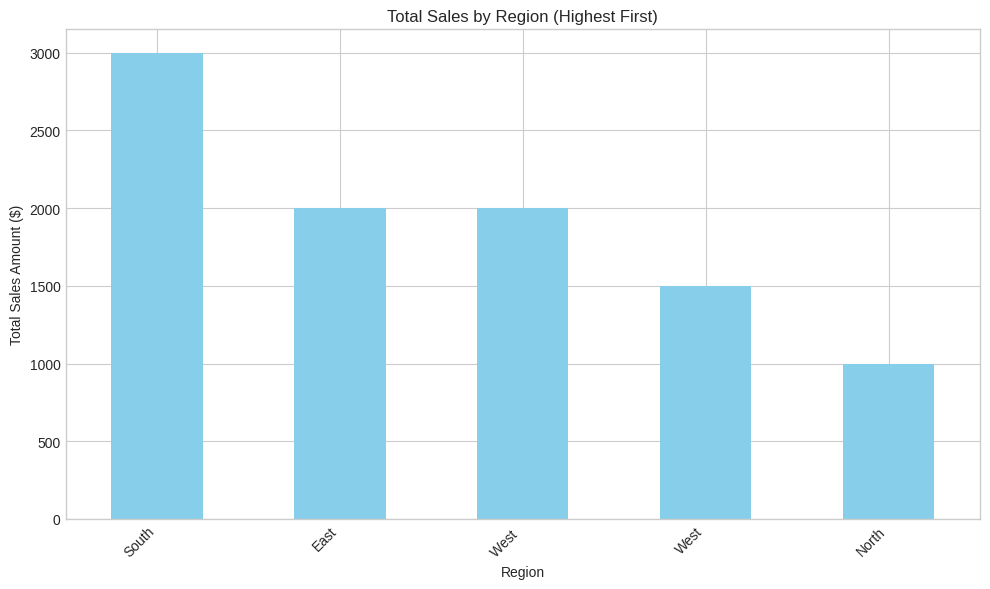


Region Sales Summary (Sorted Descending):


,Region,Amount
0,South,3000.0
1,East,2000.0
2,West,2000.0
3,West,1500.0
4,North,1000.0



--- P3: Month-wise Sales Plot & Inference ---


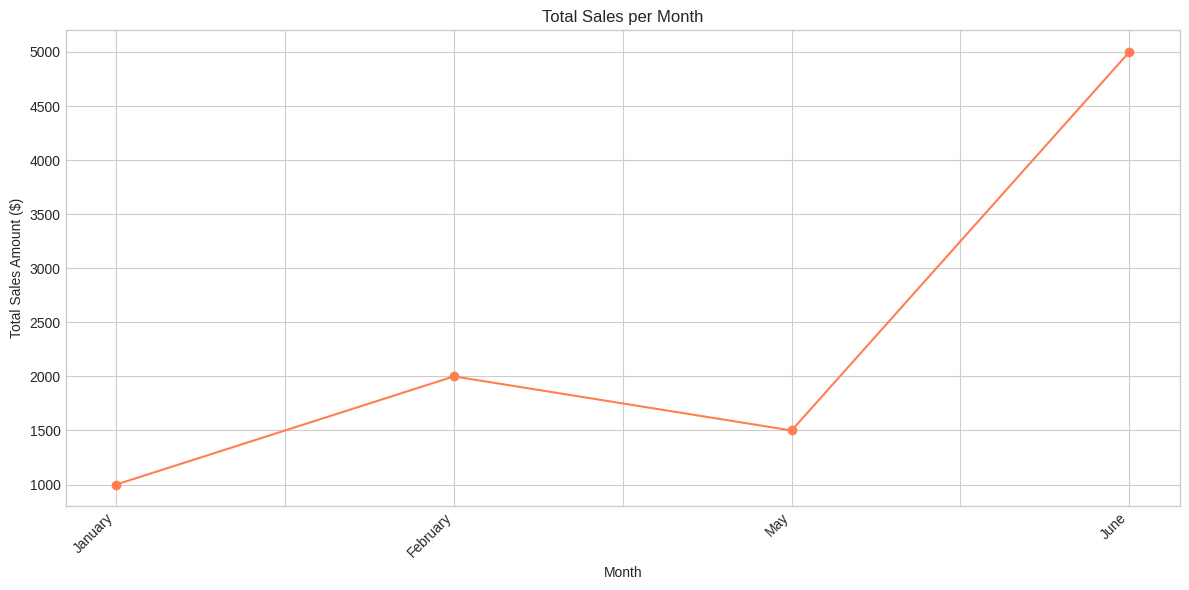


Inference from Month-wise Sales Plot:
- Sales peaked in June ($5,000.00).
- The lowest sales occurred in January ($1,000.00).
- The average monthly sales across the observed period is $2,375.00.
- Visual inspection of the plot helps identify potential seasonality or trends (e.g., growth/decline over the months shown).
- There's a significant variation in sales, with the peak month (June) having more than double the sales of the lowest month (January).


In [4]:
# Check if DataFrame exists and has required columns
if df is not None and 'Date' in df.columns and 'Amount' in df.columns:
    # Ensure 'Amount' is numeric for calculations. Re-apply just in case.
    df['Amount'] = pd.to_numeric(df['Amount'], errors='coerce')

    # Create a cleaned version for analysis, dropping rows with invalid Amount or Date
    df_analysis = df.dropna(subset=['Amount', 'Date']).copy() # Use copy to avoid SettingWithCopyWarning

    if not df_analysis.empty:
        # P1: Find which month had the highest sales
        print("\n--- P1: Highest Sales Month ---")
        # Extract month name into a new 'Month' column
        df_analysis['Month'] = df_analysis['Date'].dt.strftime('%B') # Full month name
        # Group by month and sum sales
        monthly_sales = df_analysis.groupby('Month')['Amount'].sum().sort_values(ascending=False)

        if not monthly_sales.empty:
            highest_sales_month = monthly_sales.index[0]
            highest_sales_amount = monthly_sales.iloc[0]
            print(f"The month with the highest sales is {highest_sales_month} with total sales of ${highest_sales_amount:,.2f}")
            print("\nMonthly Sales Summary (Sorted Descending):")
            # Use display() for better formatting
            from IPython.display import display
            display(monthly_sales.reset_index())
        else:
            print("Could not calculate monthly sales. Check 'Date' and 'Amount' data after cleaning.")

        # P2: Plot region-wise sales data showing the highest sales first
        print("\n--- P2: Region-wise Sales Plot ---")
        if 'Region' in df_analysis.columns:
            # Group by region, sum sales, and sort
            # Fill potential NaN regions with 'Unknown' for plotting purposes
            region_sales = df_analysis.fillna({'Region': 'Unknown'}).groupby('Region')['Amount'].sum().sort_values(ascending=False)

            if not region_sales.empty:
                plt.figure(figsize=(10, 6))
                bars = region_sales.plot(kind='bar', color='skyblue')
                plt.title('Total Sales by Region (Highest First)')
                plt.xlabel('Region')
                plt.ylabel('Total Sales Amount ($)')
                plt.xticks(rotation=45, ha='right')
                # Add labels to bars for clarity
                # for bar in bars.patches:
                #    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'${bar.get_height():,.0f}', 
                #             ha='center', va='bottom', fontsize=9)
                plt.tight_layout() # Adjust layout to prevent labels overlapping
                plt.show()
                print("\nRegion Sales Summary (Sorted Descending):")
                display(region_sales.reset_index())
            else:
                print("Could not calculate region-wise sales. Check 'Region' and 'Amount' data after cleaning.")
        else:
            print("Skipping P2: 'Region' column not found in the analysis DataFrame.")

        # P3: Plot month-wise sales data and provide inference
        print("\n--- P3: Month-wise Sales Plot & Inference ---")
        if not monthly_sales.empty:
            # Re-order monthly sales by calendar month for plotting trend
            month_order = ['January', 'February', 'March', 'April', 'May', 'June', 
                           'July', 'August', 'September', 'October', 'November', 'December']
            # Use pd.Categorical to ensure correct sorting even if some months are missing
            monthly_sales.index = pd.Categorical(monthly_sales.index, categories=month_order, ordered=True)
            monthly_sales_ordered = monthly_sales.sort_index()

            plt.figure(figsize=(12, 6))
            monthly_sales_ordered.plot(kind='line', marker='o', linestyle='-', color='coral')
            plt.title('Total Sales per Month')
            plt.xlabel('Month')
            plt.ylabel('Total Sales Amount ($)')
            plt.xticks(rotation=45, ha='right')
            plt.grid(True)
            plt.tight_layout()
            plt.show()

            # Inference
            print("\nInference from Month-wise Sales Plot:")
            if len(monthly_sales_ordered) > 1:
                 peak_month = monthly_sales_ordered.idxmax()
                 peak_value = monthly_sales_ordered.max()
                 trough_month = monthly_sales_ordered.idxmin()
                 trough_value = monthly_sales_ordered.min()
                 average_sales = monthly_sales_ordered.mean()
                 print(f"- Sales peaked in {peak_month} (${peak_value:,.2f}).")
                 print(f"- The lowest sales occurred in {trough_month} (${trough_value:,.2f}).")
                 print(f"- The average monthly sales across the observed period is ${average_sales:,.2f}.")
                 print("- Visual inspection of the plot helps identify potential seasonality or trends (e.g., growth/decline over the months shown).")
                 # Example: Check for significant drop/increase
                 if peak_value > 2 * trough_value:
                     print(f"- There's a significant variation in sales, with the peak month ({peak_month}) having more than double the sales of the lowest month ({trough_month}).")
            elif len(monthly_sales_ordered) == 1:
                 print(f"- Only one month of data ({monthly_sales_ordered.index[0]}) is available after cleaning, with sales of ${monthly_sales_ordered.iloc[0]:,.2f}. Cannot determine monthly trends.")
            else: # Should not happen if monthly_sales wasn't empty, but as a safeguard
                 print("- No valid monthly sales data to plot or analyze.")
        else:
            print("Could not generate month-wise sales plot (no monthly sales data calculated).")
    else:
        print("Skipping Sales Analysis (P1, P2, P3): No valid 'Amount' or 'Date' data available after cleaning.")
else:
    print("DataFrame not loaded or required columns ('Date', 'Amount') missing. Skipping Sales Analysis.")

### 4. Bonus: Fill Missing Amounts and Re-run Analysis


--- Bonus: Processing Missing Amounts ---
Initial missing 'Amount' values: 2

Average Amount per Product (used for filling NaNs):


,Product,Amount
0,D1-Shirt,2000.000000
1,D1Shirt,2000.000000
2,G2-Blazers,1833.333333
3,K3-Trousers,1500.000000
4,g2-Blazers,2000.000000



Filled 2 missing 'Amount' values.
Final missing 'Amount' values after bonus processing: 0

--- Re-running Analysis with Filled Amounts (Bonus) ---

--- P1 Bonus: Highest Sales Month ---
(Bonus) Highest sales month: June ($5,000.00)

(Bonus) Monthly Sales Summary:


,Month,Amount
0,June,5000.0
1,February,2000.0
2,March,2000.0
3,April,1500.0
4,May,1500.0
5,January,1000.0



--- P2 Bonus: Region-wise Sales Plot ---


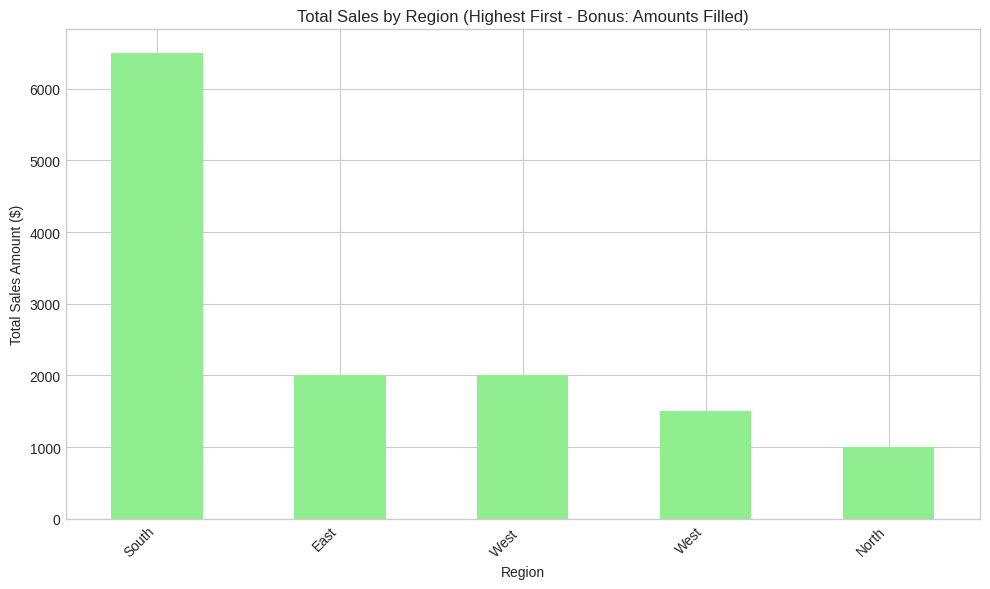


(Bonus) Region Sales Summary:


,Region,Amount
0,South,6500.0
1,East,2000.0
2,West,2000.0
3,West,1500.0
4,North,1000.0



--- P3 Bonus: Month-wise Sales Plot & Inference ---


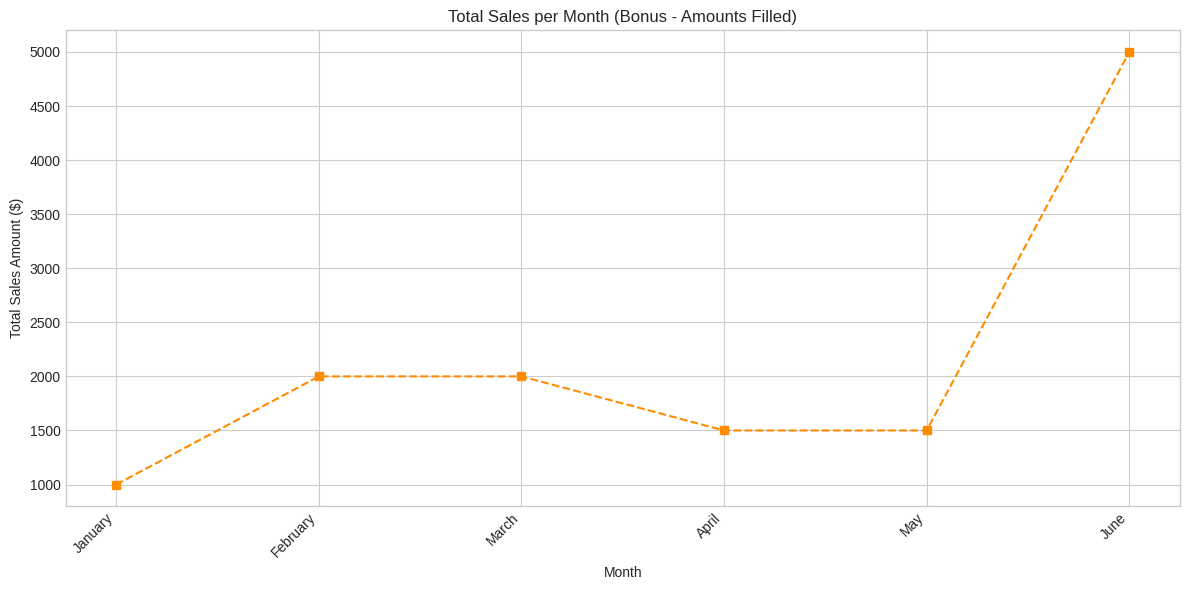


(Bonus) Inference: Compare this plot to the original month-wise plot (if generated).
- Filling missing amounts with averages tends to slightly increase overall sales figures and potentially smooth out sharp drops if missing values were numerous during low periods.
- The overall trend and the peak/trough months may or may not change significantly, depending on the number and distribution of the initially missing values.


In [5]:
# Check if DataFrame exists and has required columns for the bonus part
if df is not None and 'Amount' in df.columns and 'Product' in df.columns:
    print("\n--- Bonus: Processing Missing Amounts ---")
    # Create a copy to keep original data intact
    df_bonus = df.copy()

    # Ensure 'Amount' is numeric (might have been loaded as object)
    df_bonus['Amount'] = pd.to_numeric(df_bonus['Amount'], errors='coerce')
    initial_missing_amounts = df_bonus['Amount'].isnull().sum()
    print(f"Initial missing 'Amount' values: {initial_missing_amounts}")

    if initial_missing_amounts > 0:
        # Calculate the average amount for each product (using non-missing values)
        # We need to compute this *before* the transform/fillna
        avg_amounts = df_bonus.groupby('Product')['Amount'].mean()
        print("\nAverage Amount per Product (used for filling NaNs):")
        # Use display() for better formatting
        from IPython.display import display
        display(avg_amounts.reset_index())

        # Fill missing 'Amount' using the calculated average for that product
        # Use transform to broadcast the mean back to the original DataFrame shape
        # lambda x: x.fillna(x.mean()) fills NaNs in each group (product) with the mean of that group
        df_bonus['Amount'] = df_bonus.groupby('Product')['Amount']\
                                   .transform(lambda x: x.fillna(x.mean()))

        # Check if any NaNs remain (this happens if a product had *only* NaN amounts initially)
        remaining_nans = df_bonus['Amount'].isnull().sum()
        if remaining_nans > 0:
            print(f"\nWarning: {remaining_nans} 'Amount' values still missing after attempting to fill with product average.")
            print("This usually means some products had no valid sales amounts to calculate an average.")
            # Option 1: Fill remaining NaNs with 0
            df_bonus['Amount'].fillna(0, inplace=True)
            print("Filled these remaining missing amounts with 0.")
            # Option 2: Fill with global average (less common)
            # global_avg = df_bonus['Amount'].mean()
            # df_bonus['Amount'].fillna(global_avg, inplace=True)
            # print(f"Filled these remaining missing amounts with the global average: {global_avg:.2f}")
            # Option 3: Keep them as NaN and handle in analysis (e.g., dropna)
            # print("These rows will be excluded from sum/mean calculations.")

        filled_count = initial_missing_amounts - df_bonus['Amount'].isnull().sum()
        print(f"\nFilled {filled_count} missing 'Amount' values.")
        print(f"Final missing 'Amount' values after bonus processing: {df_bonus['Amount'].isnull().sum()}")

        # --- Re-run P1, P2, P3 with the updated DataFrame (df_bonus) ---
        print("\n--- Re-running Analysis with Filled Amounts (Bonus) ---")

        # Create a cleaned version for bonus analysis, dropping rows with invalid Date
        df_bonus_analysis = df_bonus.dropna(subset=['Date']).copy() # Use copy
        # Ensure Amount is numeric (should be, but safe to check)
        df_bonus_analysis['Amount'] = pd.to_numeric(df_bonus_analysis['Amount'], errors='coerce')
        # Drop any rows where Amount might *still* be NaN (e.g., if we didn't fill remaining NaNs with 0)
        df_bonus_analysis.dropna(subset=['Amount'], inplace=True)

        if not df_bonus_analysis.empty:
            # P1 Bonus: Highest Sales Month
            print("\n--- P1 Bonus: Highest Sales Month ---")
            df_bonus_analysis['Month'] = df_bonus_analysis['Date'].dt.strftime('%B')
            monthly_sales_bonus = df_bonus_analysis.groupby('Month')['Amount'].sum().sort_values(ascending=False)
            if not monthly_sales_bonus.empty:
                highest_sales_month_bonus = monthly_sales_bonus.index[0]
                highest_sales_amount_bonus = monthly_sales_bonus.iloc[0]
                print(f"(Bonus) Highest sales month: {highest_sales_month_bonus} (${highest_sales_amount_bonus:,.2f})")
                print("\n(Bonus) Monthly Sales Summary:")
                display(monthly_sales_bonus.reset_index())
            else:
                print("(Bonus) Could not calculate monthly sales.")

            # P2 Bonus: Region-wise Sales Plot
            print("\n--- P2 Bonus: Region-wise Sales Plot ---")
            if 'Region' in df_bonus_analysis.columns:
                region_sales_bonus = df_bonus_analysis.fillna({'Region': 'Unknown'}).groupby('Region')['Amount'].sum().sort_values(ascending=False)
                if not region_sales_bonus.empty:
                    plt.figure(figsize=(10, 6))
                    region_sales_bonus.plot(kind='bar', color='lightgreen')
                    plt.title('Total Sales by Region (Highest First - Bonus: Amounts Filled)')
                    plt.xlabel('Region')
                    plt.ylabel('Total Sales Amount ($)')
                    plt.xticks(rotation=45, ha='right')
                    plt.tight_layout()
                    plt.show()
                    print("\n(Bonus) Region Sales Summary:")
                    display(region_sales_bonus.reset_index())
                else:
                     print("(Bonus) Could not calculate region-wise sales.")
            else:
                 print("(Bonus) Skipping P2: 'Region' column not found.")

            # P3 Bonus: Month-wise Sales Plot
            print("\n--- P3 Bonus: Month-wise Sales Plot & Inference ---")
            if not monthly_sales_bonus.empty:
                month_order = ['January', 'February', 'March', 'April', 'May', 'June', 
                               'July', 'August', 'September', 'October', 'November', 'December']
                monthly_sales_bonus.index = pd.Categorical(monthly_sales_bonus.index, categories=month_order, ordered=True)
                monthly_sales_bonus_ordered = monthly_sales_bonus.sort_index()

                plt.figure(figsize=(12, 6))
                monthly_sales_bonus_ordered.plot(kind='line', marker='s', linestyle='--', color='darkorange') # Different style
                plt.title('Total Sales per Month (Bonus - Amounts Filled)')
                plt.xlabel('Month')
                plt.ylabel('Total Sales Amount ($)')
                plt.xticks(rotation=45, ha='right')
                plt.grid(True)
                plt.tight_layout()
                plt.show()
                # Add inference for bonus plot
                print("\n(Bonus) Inference: Compare this plot to the original month-wise plot (if generated).") 
                print("- Filling missing amounts with averages tends to slightly increase overall sales figures and potentially smooth out sharp drops if missing values were numerous during low periods.")
                print("- The overall trend and the peak/trough months may or may not change significantly, depending on the number and distribution of the initially missing values.")
            else:
                print("(Bonus) Could not generate month-wise sales plot.")
        else:
            print("Skipping Bonus Analysis (P1, P2, P3): No valid 'Date' or 'Amount' data available after cleaning the bonus DataFrame.")

    else: # No initial missing amounts
        print("No missing 'Amount' values to fill. Skipping Bonus analysis section.")
elif df is None:
    print("DataFrame not loaded. Skipping Bonus section.")
else: # df exists but required columns are missing
    print("Required columns ('Amount', 'Product') missing. Skipping Bonus section.")


### End of Analysis